In [1]:
import qutip as qt
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import Image
import tqdm
import time
from matplotlib.colors import LinearSegmentedColormap

In [2]:
import warnings

# Suppress only DeprecationWarning
warnings.filterwarnings('ignore', category=FutureWarning)

In [3]:
#Pauli matrices
sx = qt.sigmax()
sy = qt.sigmay()
sz = qt.sigmaz()

#Identity
I = qt.qeye(2)

#sigma+-
sm = qt.destroy(2)
sp = qt.create(2)

In [4]:
def initialize_system(size, alpha, beta): 
    #Initial state
    #Initialize first spin in a superposition of |0> and |1>
    #Initialize the rest of the spins in |0>
    t_i = time.time()
    psi0_1 = alpha*qt.basis(2,0) + beta*qt.basis(2,1)
    state_list = [psi0_1] + [qt.basis(2, 0)] * (size - 1)

    #Total state is product state of spins
    initial_state = qt.tensor(state_list) 

    t_f = time.time()

    print("State initialization:", t_f - t_i)

    print("Initializing system of size", size, "\n"
          "First spin in state {:.4f} |0> + {:.4f} |1>\n".format(alpha, beta))
    
    return initial_state


def generate_target(size, alpha, beta): 
    #Initial state
    #Initialize first spin in a superposition of |0> and |1>
    #Initialize the rest of the spins in |0>
    t_i = time.time()
    psi0_1 = alpha*qt.basis(2,0) + beta*qt.basis(2,1)
    state_list =  [qt.basis(2, 0)] * (size - 1) + [psi0_1]

    #Total state is product state of spins
    final_state = qt.tensor(state_list) 

    t_f = time.time()

    print("State initialization:", t_f - t_i)

    print("Initializing system of size", size, "\n"
          "First spin in state {:.4f} |0> + {:.4f} |1>\n".format(alpha, beta))
    
    return final_state


def initialize_system_2(size, alpha, beta): 
      #Initial state
      #Superposition of |01> and |10> in the first two spins
      psi_0 = [qt.basis(2,1)] + [qt.basis(2, 0)] * (size - 1)
      psi_1 = [qt.basis(2, 0)] + [qt.basis(2,1)] + [qt.basis(2, 0)] * (size - 2)
      initial_state = alpha*qt.tensor(psi_0) + beta*qt.tensor(psi_1)
      return initial_state


def initialize_two_end_state(size):
      psi_0 = 1/np.sqrt(2)*(qt.basis(2,1) + qt.basis(2, 0))
      psi = [psi_0] + [qt.basis(2, 0)]*(size - 2) + [psi_0]
      initial_state = qt.tensor(psi)
      return initial_state

In [5]:
#Define the coupling values
def coupling_definitions(size, factor):
    strengths = np.zeros(size-1)
    for i in range(size-1):
        strengths[i] = 0.5*factor*np.sqrt((i+1)*(size-i-1))
    return strengths


In [6]:
def Hamiltonian(size, couplings):    
# Setup operators for individual qubits
    sx_list, sy_list, sz_list = [], [], []

    t_i = time.time()

    #for each value of i it puts the paulis in different positions of the list, then does IxIxI...sigma_ixIxI...xI
    for i in range(size):
        #list of 2x2 identity matrices
        op_list = [qt.qeye(2)] * size
        #replace i-th element with sigma_x
        op_list[i] = sx
        #create matrices of 2^Nx2^N
        sx_list.append(qt.tensor(op_list))
        #do the same for sigma_y and sigma_z
        op_list[i] = sy
        sy_list.append(qt.tensor(op_list))
        op_list[i] = sz
        sz_list.append(qt.tensor(op_list))

    #Build Hamiltonian
    Ham = 0
    # Interaction terms
    for n in range(size - 1):
        Ham += 0.5 * couplings[n] * sx_list[n] * sx_list[n + 1]
        Ham += 0.5 * couplings[n] * sy_list[n] * sy_list[n + 1]

    t_f = time.time()

    print("Building Hamiltonian: ", t_f - t_i)
    
    return Ham, sx_list, sy_list, sz_list   

In [7]:
def time_evolution(Ham, sigma_z_list,  initial_state, initial_time, final_time, timesteps): 
    times = np.linspace(initial_time, final_time, timesteps)
    #apply hamiltonian to initial state and don't track any observables
    options = {
    'method': 'adams', 
    'progress_bar': 'tqdm'
}
    t_i = time.time()
    simulation_results = qt.sesolve(Ham, initial_state, times, options = options)
    t_f = time.time()
    print("Sesolve evolution:", t_f - t_i)


    print("Simulated evolution from time", initial_time, "to", final_time, "in", timesteps, "steps \n")

    return simulation_results

In [8]:
def calculate_z_difference(initial_state, state_evolution, sigma_z_list):    
    #Find minimum difference between expected Z val of last spin and initial Z of first spin

    #calculate expectation value of sz for each spin
    t_i = time.time()
    magn_0 = np.array(qt.expect(initial_state*initial_state.dag(), sigma_z_list))
    magn_t = np.array(qt.expect(state_evolution, sigma_z_list))
    t_f = time.time()
    print("Z expectations:", t_f - t_i)

    target_sz = magn_0[0]
    min_diff = 1
    min_index = 0
    #Loop over the time steps
    for index, val in enumerate(magn_t):
        #update if new minimum is found, checking only magn of the last spin
        if abs(val[-1] - target_sz) < min_diff:
            min_diff = abs(val[-1] - target_sz)
            min_index = index

    print("Minimum difference between expected Z val of last spin and initial Z of first spin is {:.4f} at time {:.0f}".format(min_diff, min_index), "\n")

    return min_diff, min_index

In [9]:
def calculate_fidelities(state_evolution, initial_state): 
    #Calculate fidelities and find maximum
    # rho_0 = qt.basis(2,1)*qt.basis(2,1).dag()
    rho_0 = (initial_state * initial_state.dag()).ptrace(0)
    fidelities = np.zeros(len(state_evolution))
    t_i = time.time()
    for index, state in enumerate(state_evolution):
        #update if new minimum is found
        rho_n = state.ptrace(N-1)
        fidelities[index] = (qt.fidelity(rho_0, rho_n))
    t_f = time.time()
    print("fidelity calculation:", t_f - t_i)

    max_fid = np.max(fidelities)
    max_fid_index = np.argmax(fidelities)

    print("Maximum fidelity is {:.4f} at time {:.0f}".format(max_fid, max_fid_index), "\n")
    
    return fidelities, max_fid, max_fid_index

In [10]:
def calculate_all_fidelities(n_spins, state_evolution, initial_state): 
    #Calculate fidelities and find maximum
    rho_0 = (initial_state * initial_state.dag()).ptrace(0)
    fidelities = np.zeros((len(state_evolution), n_spins))

    t_i = time.time()
    for index, state in enumerate(state_evolution):
        #update if new minimum is found
        for site in range(n_spins):
            rho_n = state.ptrace(site)
            fidelities[index, site] = (qt.fidelity(rho_0, rho_n))

    t_f = time.time()
    print("fidelity calculation:", t_f - t_i)


    max_fid = [np.max(fidelities[:,i]) for i in range(n_spins)]
    max_fid_index = [np.argmax(fidelities[:,i]) for i in range(n_spins)]

    #print("Maximum fidelity is {:.4f} at time {:.0f}".format(max_fid, max_fid_index), "\n")
    
    return fidelities, max_fid, max_fid_index

#create 2d array of zeros



In [11]:
def calculate_z_expectation_values(n_spins, initial_state, state_evolution, sigma_z_list):    
    #Find minimum difference between expected Z val of last spin and initial Z of first spin
    #calculate expectation value of sz for each spin
    magn_t = np.array(qt.expect(state_evolution, sigma_z_list))
    #find maximums
    max_magn_i = [np.max(magn_t[:,i]) for i in range(n_spins)]
    max_magn_i_index = [np.argmax(magn_t[:,i]) for i in range(n_spins)]

    return magn_t, max_magn_i, max_magn_i_index

In [12]:
def calculate_concurrence(n_spins, state_evolution):
    concurrence = []
    for index, state in enumerate(state_evolution):
        rho_1 = state.ptrace([0, n_spins-1])
        concurrence.append(qt.concurrence(rho_1))
    return concurrence
    

In [13]:
def calculate_full_fidelity(n_spins, state_evolution, target_state = None): 
    #Calculate fidelities and find maximum
    if target_state is None:
        state_list = [qt.basis(2, 0)] * (size - 1) + [psi0_1] 
        target_state = qt.tensor(state_list)
    
    #target_state = target_state * target_state.dag()

    fidelity = np.zeros(len(state_evolution.times))

    for index, state in enumerate(state_evolution.states):
         fidelity[index] = (qt.fidelity(target_state, state))

    return fidelity


def calculate_z_expectation_values(n_spins, initial_state, state_evolution, sigma_z_list):    
    #Find minimum difference between expected Z val of last spin and initial Z of first spin
    #calculate expectation value of sz for each spin
    magn_t = np.array([[qt.expect(op, state) for op in sigma_z_list] for state in state_evolution.states])
    #find maximums
    max_magn_i = [np.max(magn_t[:,i]) for i in range(n_spins)]
    max_magn_i_index = [np.argmax(magn_t[:,i]) for i in range(n_spins)]

    return magn_t, max_magn_i, max_magn_i_index

## Main program

In [18]:

#Prefactor of Hamiltonian
lmd = 0.5

#Evolution parameters
ti = 0
tf = 6.25
Nstep = 500
max_fidelities = []
# a_list = np.linspace(0, 1, 20)
a_list = [0.5]
# N_list = range(3,10)
N_list = [10]
for index_n, value_n in enumerate(N_list):
    for index_a, value_a in enumerate(a_list):
        N = value_n
        a = value_a
        b = np.sqrt(1 - a*a)
        #Create initial state
        psi0 = initialize_system(N, a, b)
        final_state = generate_target(N, a, b) 
        # psi0 = initialize_two_end_state(N)
        #Set coupling strengths
        Jn = coupling_definitions(N, lmd)
        #Create Hamiltonian
        H, sxl, syl, szl = Hamiltonian(N, Jn)
        #Simulate time evolution
        result = time_evolution(H, szl, psi0, ti, tf, Nstep)
        # Calculate difference between expectation values and fidelity of spins 1 and N
        # min_diff, min_index = calculate_z_difference(psi0, states, szl)
        full_fidelity = calculate_full_fidelity(N, result, final_state)
        magnetizations, min_magn, min_magn_index = calculate_z_expectation_values(N, psi0, result, szl)
        # conc = calculate_concurrence(N, states)
        # Evolution of z magn in last spin
        # exp_z_n = [exp_sz[i][-1] for i in range(Nstep)]
        # max_fidelities.append(mf)
        print(np.argmin(magnetizations[:,-1]))

State initialization: 0.001501321792602539
Initializing system of size 10 
First spin in state 0.5000 |0> + 0.8660 |1>

State initialization: 0.0008039474487304688
Initializing system of size 10 
First spin in state 0.5000 |0> + 0.8660 |1>

Building Hamiltonian:  0.003983974456787109


100%|██████████| 499/499 [00:00<00:00, 23755.00it/s]

Sesolve evolution: 0.0239260196685791
Simulated evolution from time 0 to 6.25 in 500 steps 

499


In [19]:
full_fidelity_1 = full_fidelity

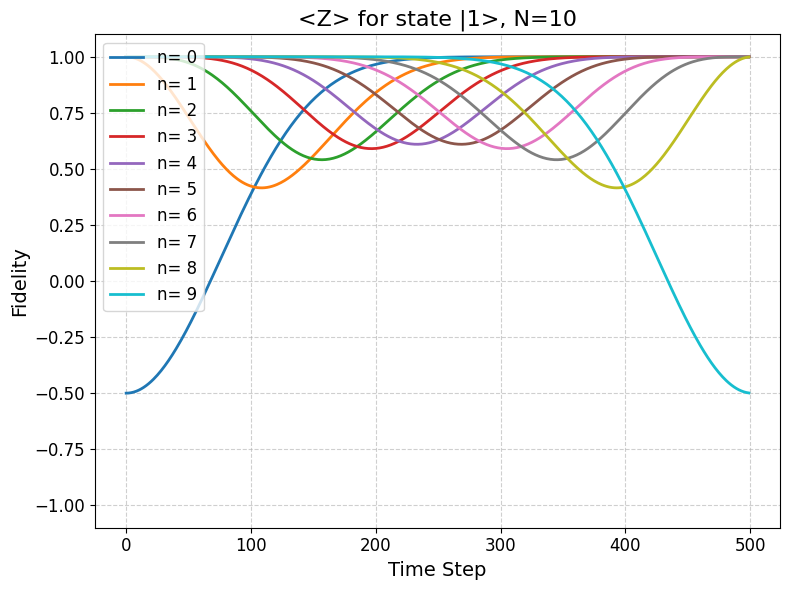

In [20]:
plt.figure(figsize=(8, 6))
# Plot each curve
for i in range(N):
    magn = magnetizations[:,i]
    num_steps = len(magn)
    
    plt.plot(range(num_steps), magn, label=f'n= {i}', linestyle='-', linewidth=2)

# Add labels, title, legend, and grid
plt.xlabel('Time Step', fontsize=14)
plt.ylabel('Fidelity', fontsize=14)
plt.ylim(-1.1, 1.1)
plt.title(f'<Z> for state |1>, N={N}', fontsize=16)
plt.legend(fontsize=12, loc='upper left')
plt.grid(True, linestyle='--', alpha=0.6)
plt.tick_params(axis='both', labelsize=12)

# Adjust layout and display
plt.tight_layout()
plt.show()

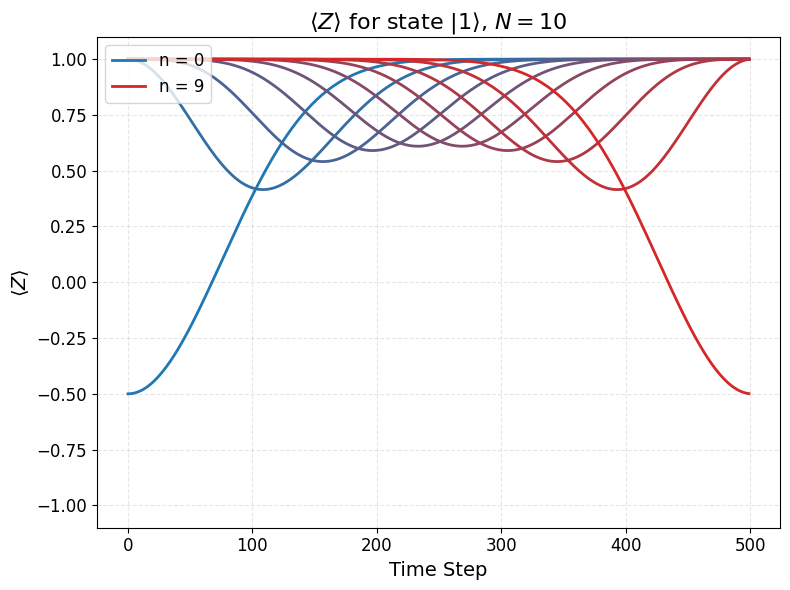

In [21]:
plt.figure(figsize=(8, 6))

# Create a colormap from color1 to color2
cmap = LinearSegmentedColormap.from_list('custom', ['#1f77b4', '#d62728'], N=N)

# Plot each curve with gradient colors
for i in range(N):
    magn = magnetizations[:,i]
    num_steps = len(magn)
    color = cmap(i/(N-1))  # Normalize to [0,1]
    plt.plot(range(num_steps), magn, color=color, linestyle='-', linewidth=2, 
             label=f'n = {i}' if (i == 0 or i == N-1) else "")

# Only show first and last in legend
handles, labels = plt.gca().get_legend_handles_labels()
if N > 2:
    handles = [handles[0], handles[-1]]
    labels = [labels[0], labels[-1]]
    plt.legend(handles, labels, fontsize=12, loc='upper left')

# Professional formatting
plt.xlabel('Time Step', fontsize=14)
plt.ylabel(r'$\langle Z \rangle$', fontsize=14)  # Using LaTeX notation
plt.ylim(-1.1, 1.1)
plt.title(r'$\langle Z \rangle$ for state $|1\rangle$, $N={}$'.format(N), fontsize=16)
plt.grid(True, linestyle='--', alpha=0.3)
plt.tick_params(axis='both', which='major', labelsize=12)

# Adjust layout and display
plt.tight_layout()
plt.show()



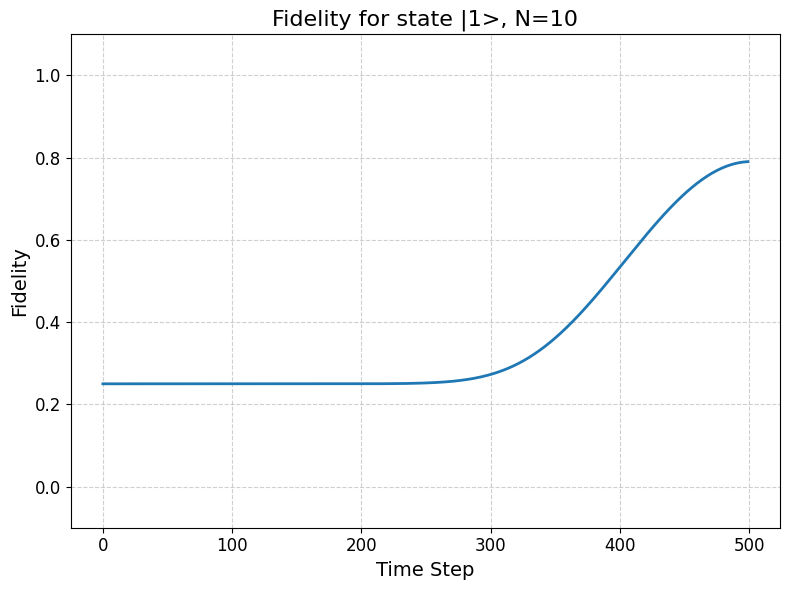

0.7903491400568095
499


In [22]:

plt.figure(figsize=(8, 6))
# Plot each curve
num_steps = len(full_fidelity)
plt.plot(range(num_steps), full_fidelity, label=f'Fidelity', linestyle='-', linewidth=2)

# Add labels, title, legend, and grid
plt.ylim(-0.1, 1.1)
plt.xlabel('Time Step', fontsize=14)
plt.ylabel('Fidelity', fontsize=14)
# plt.title('<Z> for N=7, J=-5, α = 1', fontsize=16)
# plt.title('Fidelity for N=7, J=5, α = 0.8', fontsize=16)
plt.title(f'Fidelity for state |1>, N={N}', fontsize=16)
# plt.legend(fontsize=12, loc='upper left')
plt.grid(True, linestyle='--', alpha=0.6)
plt.tick_params(axis='both', labelsize=12)

# Adjust layout and display
plt.tight_layout()
plt.show()

print(max(full_fidelity))
print(np.argmax(full_fidelity))

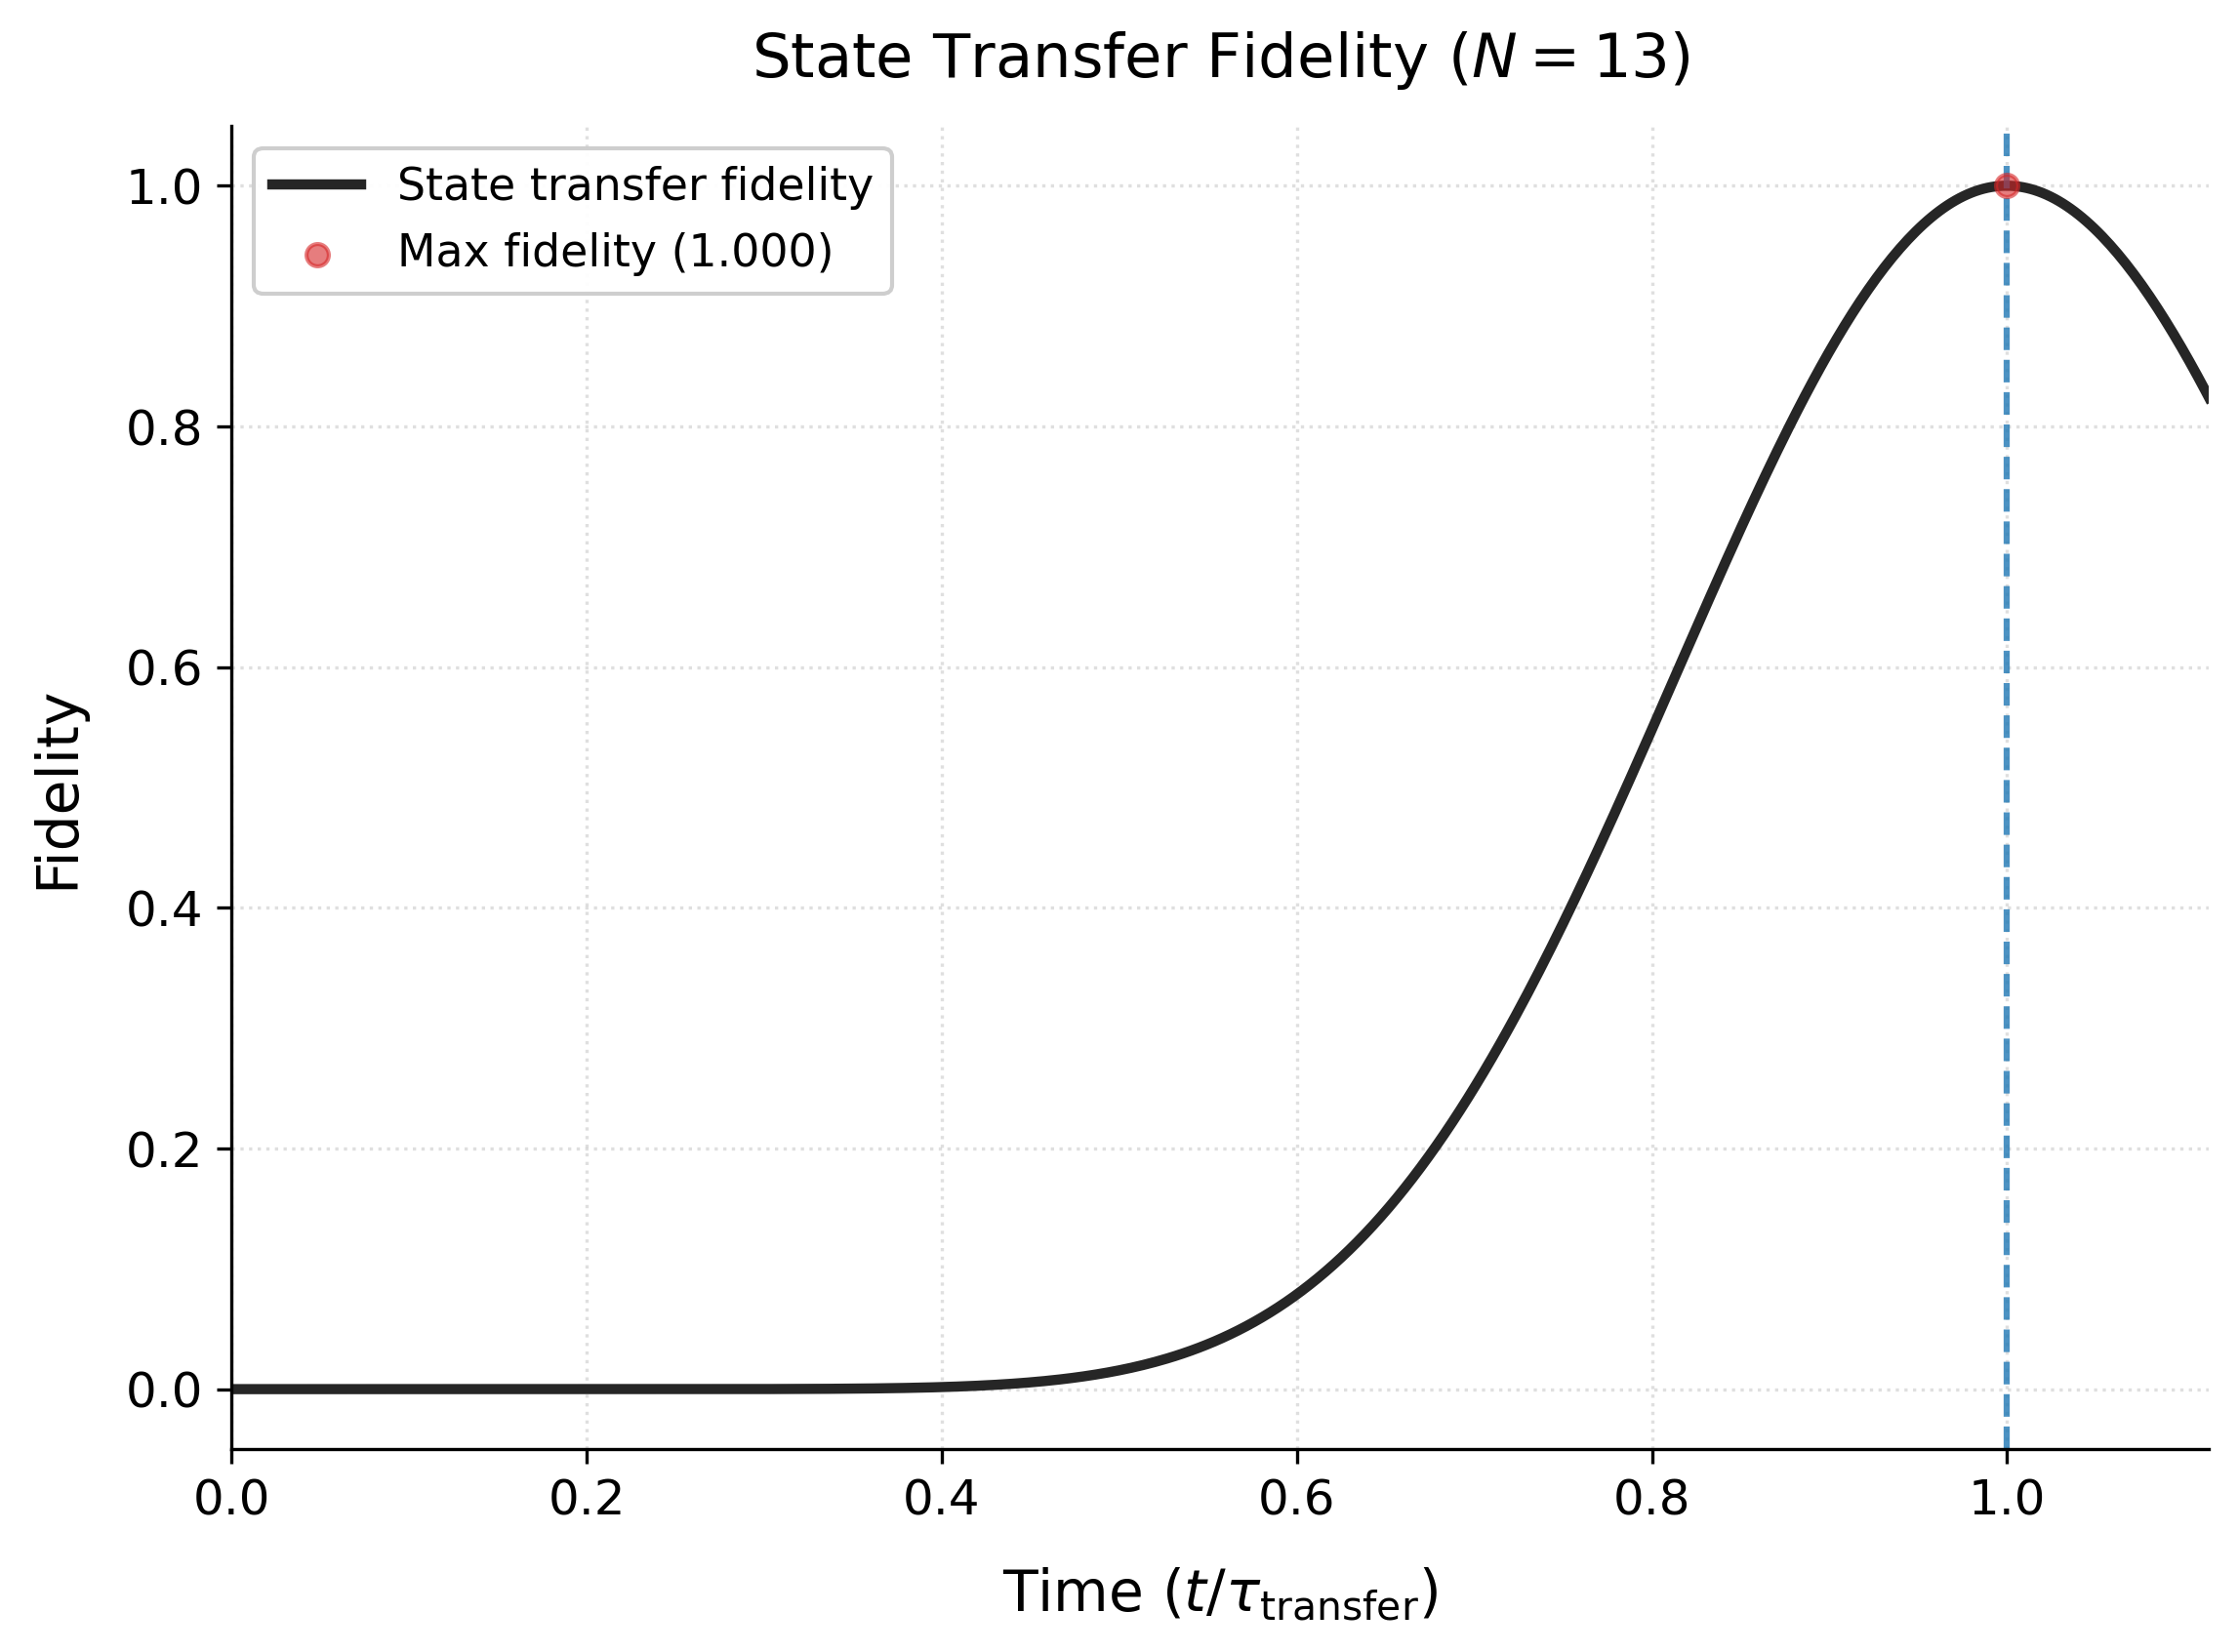

Maximum fidelity: 0.999999
Original τ_transfer timescale: 6.28


In [40]:
import matplotlib.pyplot as plt
import numpy as np

# Find maximum fidelity point
max_fidelity = np.max(full_fidelity_1)
max_time_idx = np.argmax(full_fidelity_1)

# Rescale time axis so maximum occurs at t/τ = 1
original_time = np.linspace(0, 7, len(full_fidelity_1))  # Original 0-7 range
rescale_factor = original_time[max_time_idx]  # This will become 1 in new units
rescaled_time = original_time / rescale_factor

# Create figure
plt.figure(figsize=(8, 6), dpi=300)

# Plot with professional styling (using black as requested)
plt.plot(rescaled_time, full_fidelity_1, 
         color='#262626',  # Professional black
         linestyle='-', 
         linewidth=2.5,
         label='State transfer fidelity')

# Main marker (subtle)
plt.scatter([1], [max_fidelity],
            color='#d62728',
            s=30,
            alpha=0.6,
            zorder=5,
            label=f'Max fidelity ({max_fidelity:.3f})')


# Add reference line at new t/τ = 1
plt.axvline(x=1, color='#1f77b4', linestyle='--', linewidth=1.5, alpha=0.8)

# Formatting
plt.ylim(-0.05, 1.05)
plt.xlim(0, rescaled_time[-1])  # Automatically scale to full range
plt.xlabel(r'Time ($t/\tau_{\mathrm{transfer}}$)', fontsize=14, labelpad=10)
plt.ylabel('Fidelity', fontsize=14, labelpad=10)
plt.title(r'State Transfer Fidelity ($N={}$)'.format(N), fontsize=15, pad=12)

# Scientific-style grid and frame
ax = plt.gca()
ax.grid(True, linestyle=':', alpha=0.4)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.tick_params(axis='both', which='major', labelsize=12)

# Simplified legend
plt.legend(fontsize=11, framealpha=0.95, loc='upper left')

# Add scale annotation
# plt.text(0.95, 0.15, 
#          r'$\tau_{\mathrm{transfer}} = %.2f$ (original units)'%rescale_factor,
#          fontsize=10, ha='right', color='#1f77b4')

# Tight layout
plt.tight_layout(pad=2.0)

# Save
plt.savefig('figures/good_figures/rescaled_fidelity.pdf', bbox_inches='tight', dpi=300)
plt.show()

# Diagnostic output
print(f"Maximum fidelity: {max_fidelity:.6f}")
print(f"Original τ_transfer timescale: {rescale_factor:.2f}")

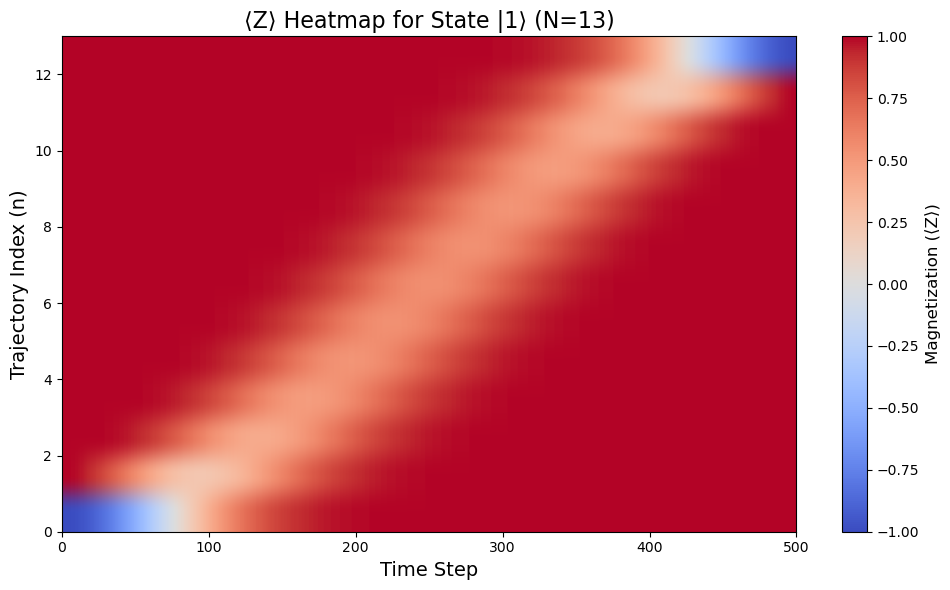

In [23]:


# Transpose to get shape (N, num_steps) for heatmap (rows = trajectories, columns = time)
heatmap_data = magnetizations.T  # Shape: (N, num_steps)

plt.figure(figsize=(10, 6))
# Create heatmap
heatmap = plt.imshow(
    heatmap_data,
    aspect='auto',
    cmap='coolwarm',  # Blue (-1) to Red (+1)
    vmin=-1,
    vmax=1,
    extent=(0, heatmap_data.shape[1], 0, heatmap_data.shape[0]),
    origin='lower'
)

# Add colorbar
cbar = plt.colorbar(heatmap)
cbar.set_label('Magnetization (⟨Z⟩)', fontsize=12)

# Labels and title
plt.xlabel('Time Step', fontsize=14)
plt.ylabel('Trajectory Index (n)', fontsize=14)
plt.title(f'⟨Z⟩ Heatmap for State |1⟩ (N={N})', fontsize=16)

# Adjust layout
plt.tight_layout()
plt.show()

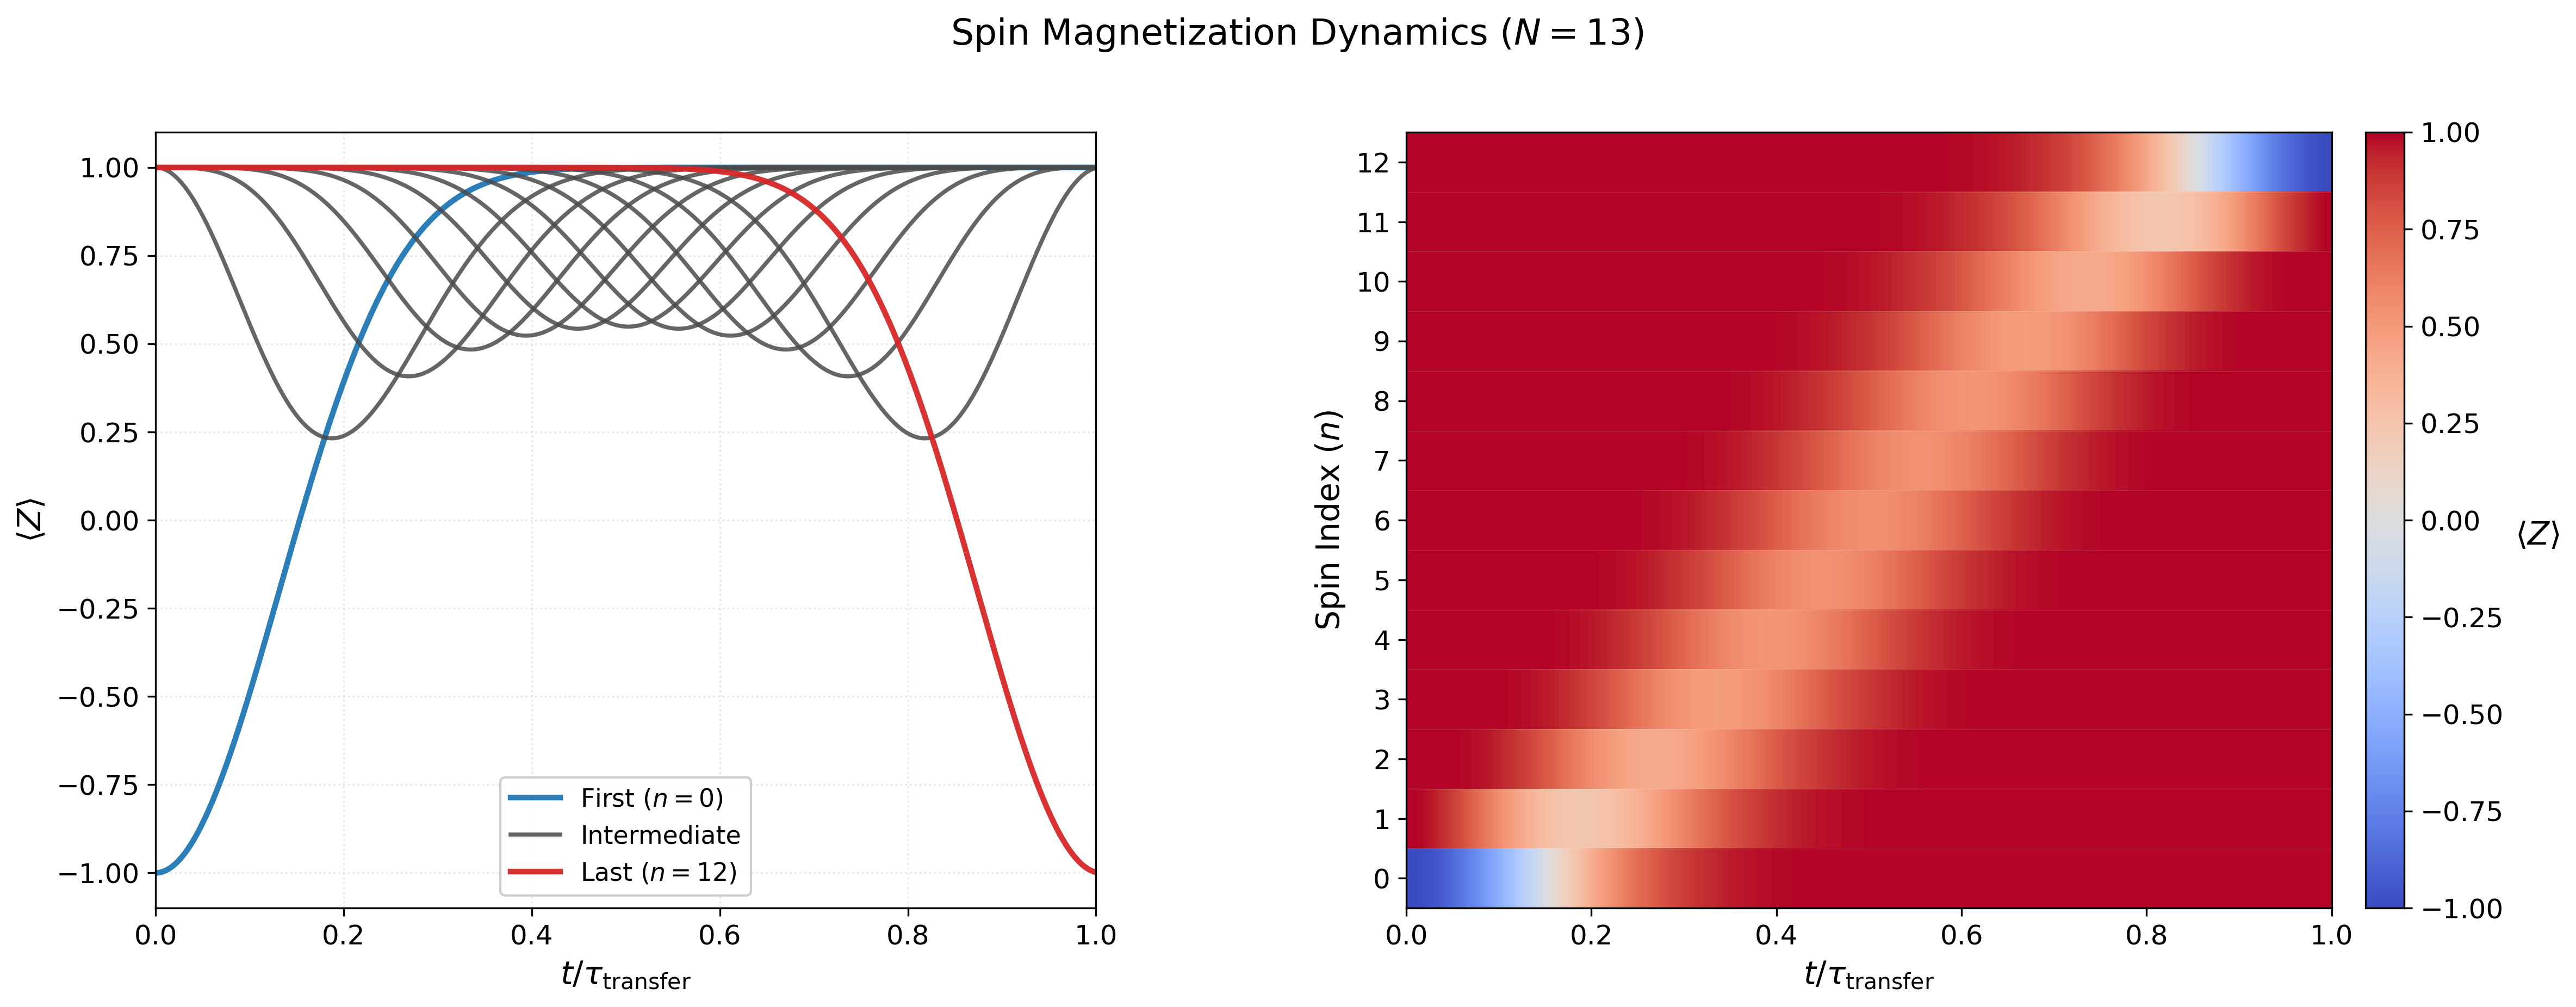

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.gridspec import GridSpec

# Create figure with side-by-side subplots
fig = plt.figure(figsize=(16, 6), dpi=300)
gs = GridSpec(1, 2, width_ratios=[1, 1.2])  # Heatmap slightly wider

# Custom colors
first_color = '#1f77b4'  # Blue
last_color = '#d62728'   # Red
middle_color = '#4a4a4a' # Dark gray

# ========== LEFT PANEL: LINE PLOT ==========
ax1 = fig.add_subplot(gs[0])

for i in range(N):
    magn = magnetizations[:,i]
    norm_time = np.linspace(0, 1, len(magn))
    
    lineprops = {
        'color': first_color if i == 0 else (last_color if i == N-1 else middle_color),
        'lw': 2.5 if i in [0, N-1] else 1.8,
        'alpha': 0.95 if i in [0, N-1] else 0.85,
        'label': r'First $(n=0)$' if i == 0 else (r'Last $(n={})$'.format(N-1) if i == N-1 else "")
    }
    if i == 1 and N > 2:
        lineprops['label'] = 'Intermediate'
    
    ax1.plot(norm_time, magn, **lineprops)

# Formatting
ax1.set_xlabel(r'$t/\tau_{\mathrm{transfer}}$', fontsize=14)
ax1.set_ylabel(r'$\langle Z \rangle$', fontsize=14)
ax1.set_ylim(-1.1, 1.1)
ax1.set_xlim(0, 1)
ax1.tick_params(labelsize=12)
ax1.grid(True, linestyle=':', alpha=0.3)

# Simplified legend
handles, labels = ax1.get_legend_handles_labels()
if N > 2:
    # Only show first, last, and one intermediate
    handles = [handles[0], handles[1], handles[-1]] if N > 2 else handles
    labels = [labels[0], 'Intermediate', labels[-1]] if N > 2 else labels
ax1.legend(handles, labels, fontsize=11, framealpha=0.95)

# ========== RIGHT PANEL: HEATMAP ==========
ax2 = fig.add_subplot(gs[1])

# Heatmap with improved display
heatmap = ax2.imshow(
    magnetizations.T,
    aspect='auto',
    cmap='coolwarm',
    vmin=-1,
    vmax=1,
    extent=(0, 1, 0, N),
    origin='lower',
    interpolation='none'  # Sharp color boundaries
)

# Colorbar with matching style
cbar = fig.colorbar(heatmap, ax=ax2, pad=0.03)
cbar.set_label(r'$\langle Z \rangle$', fontsize=14, rotation=0, labelpad=15)
cbar.ax.tick_params(labelsize=12)

# Clean axis formatting
ax2.set_xlabel(r'$t/\tau_{\mathrm{transfer}}$', fontsize=14)
ax2.set_ylabel('Spin Index ($n$)', fontsize=14)
ax2.set_yticks(np.arange(0.5, N+0.5, 1))
ax2.set_yticklabels(np.arange(N))
ax2.tick_params(labelsize=12)

# Subtle horizontal guides (reduced visibility)
for n in range(1, N):
    ax2.axhline(n, color='white', lw=0.3, alpha=0.15)

# ========== GLOBAL FORMATTING ==========
plt.suptitle(r'Spin Magnetization Dynamics ($N={}$)'.format(N), 
             fontsize=16, y=1.02)

# Final layout adjustment
plt.tight_layout()
plt.subplots_adjust(wspace=0.3)  # Horizontal spacing

# Save
plt.savefig('figures/good_figures/side_by_side_spin_dynamics.pdf', bbox_inches='tight', dpi=300)
plt.show()

In [25]:
for i in range(N):
    print("Max F for spin", i, ":", mf[i], "at step", mfi[i])

NameError: name 'mf' is not defined

In [26]:
max_fidelity_end = mf[-1]
max_fidelity_index_end = mfi[-1]

print(max_fidelity_index_end)

for i in range(N):
    print("Fidelity of spin", i, "at time of max fidelity of the chain end:", f_i[max_fidelity_index_end,i])


NameError: name 'mf' is not defined

In [27]:
total_magnetization = magnetizations_c

plt.figure(figsize=(8, 6))
# Plot each curve
for i in range(N):
    magn = total_magnetization[:,i]
    num_steps = len(magn)
    
    plt.plot(range(num_steps), magn, label=f'n= {i}', linestyle='-', linewidth=2)

# Add labels, title, legend, and grid
plt.xlabel('Time Step', fontsize=14)
plt.ylabel('<Z>', fontsize=14)
plt.ylim(-0.1, 1.1)
# plt.title('<Z> for N=7, J=-5, α = 1', fontsize=16)
plt.title('<Z> for N=9', fontsize=16)
plt.legend(fontsize=12, loc='lower right')
plt.grid(True, linestyle='--', alpha=0.6)
plt.tick_params(axis='both', labelsize=12)

# Adjust layout and display
plt.tight_layout()
plt.show()


for i in range(N):
    magn = total_magnetization[:,i]
    print(magn[0])


for i in range(N):
    magn = total_magnetization[:,i]
    print(magn[125])

NameError: name 'magnetizations_c' is not defined

In [28]:
plt.plot(range(num_steps), conc, label=f'n= {i}', linestyle='-', linewidth=2)

# Add labels, title, legend, and grid
plt.xlabel('Time Step', fontsize=14)
plt.ylabel('C', fontsize=14)
plt.ylim(-0.1, 1.1)
# plt.title('C for N=7, J=-5, α = 1', fontsize=16)
plt.title('Concurrence for N=9', fontsize=16)
plt.grid(True, linestyle='--', alpha=0.6)
plt.tick_params(axis='both', labelsize=12)

# Adjust layout and display
plt.tight_layout()
plt.show()

NameError: name 'conc' is not defined

In [29]:
plt.figure(figsize=(8, 6))
# Plot each curve
for i in range(N):
    fidelity = f_i[:,i]
    plt.plot(range(Nstep), fidelity, label=f'n= {i}', linestyle='-', linewidth=2)

# Add labels, title, legend, and grid
plt.xlabel('Time Step', fontsize=14)
plt.ylabel('Fidelity', fontsize=14)
plt.title('Evolution of Fidelity for N=7', fontsize=16)
plt.legend(fontsize=12, loc='upper right')
plt.grid(True, linestyle='--', alpha=0.6)
plt.tick_params(axis='both', labelsize=12)

# Adjust layout and display
plt.tight_layout()
plt.show()

NameError: name 'f_i' is not defined

<Figure size 800x600 with 0 Axes>

NameError: name 'f_i' is not defined

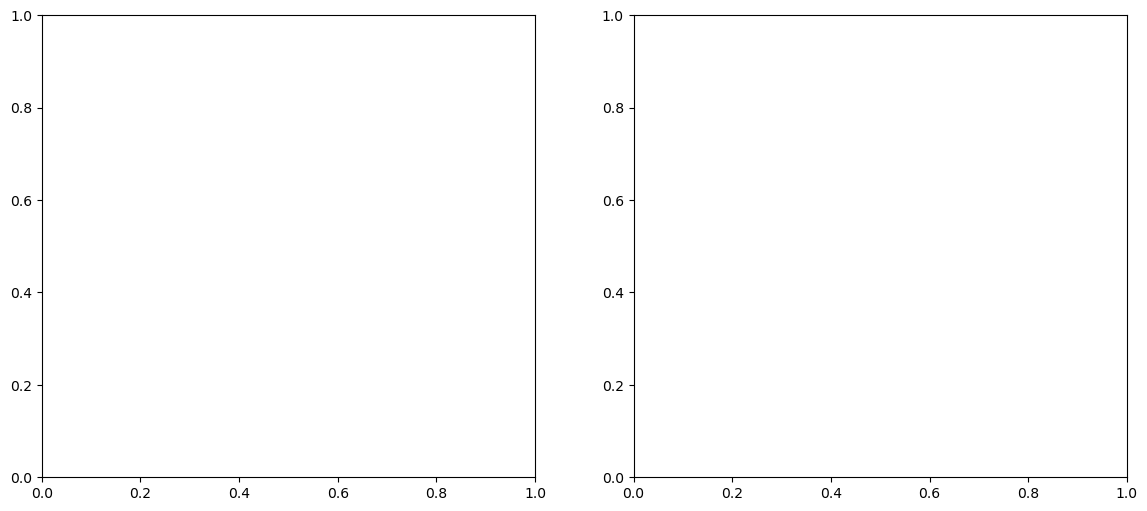

In [30]:
# Create a figure with two subplots side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Plot 1: Magnetization (exp_z_n)
ax1.plot(range(Nstep), f_i, label=r'$\langle S_z \rangle$', color='blue', linestyle='-', linewidth=2)
ax1.set_xlabel('Time Step', fontsize=14)
ax1.set_ylabel('Magnetization', fontsize=14)
ax1.set_title('Evolution of Magnetization', fontsize=16)
ax1.legend(fontsize=12)
ax1.grid(True, linestyle='--', alpha=0.6)
ax1.tick_params(axis='both', labelsize=12)

# Plot 2: Fidelity (f_i)
ax2.plot(range(Nstep), f_i, label='Fidelity', color='red', linestyle='-', linewidth=2)
ax2.set_xlabel('Time Step', fontsize=14)
ax2.set_ylabel('Fidelity', fontsize=14)
ax2.set_title('Evolution of Fidelity', fontsize=16)
ax2.legend(fontsize=12)
ax2.grid(True, linestyle='--', alpha=0.6)
ax2.tick_params(axis='both', labelsize=12)

# Adjust layout and display
plt.tight_layout()
plt.show()

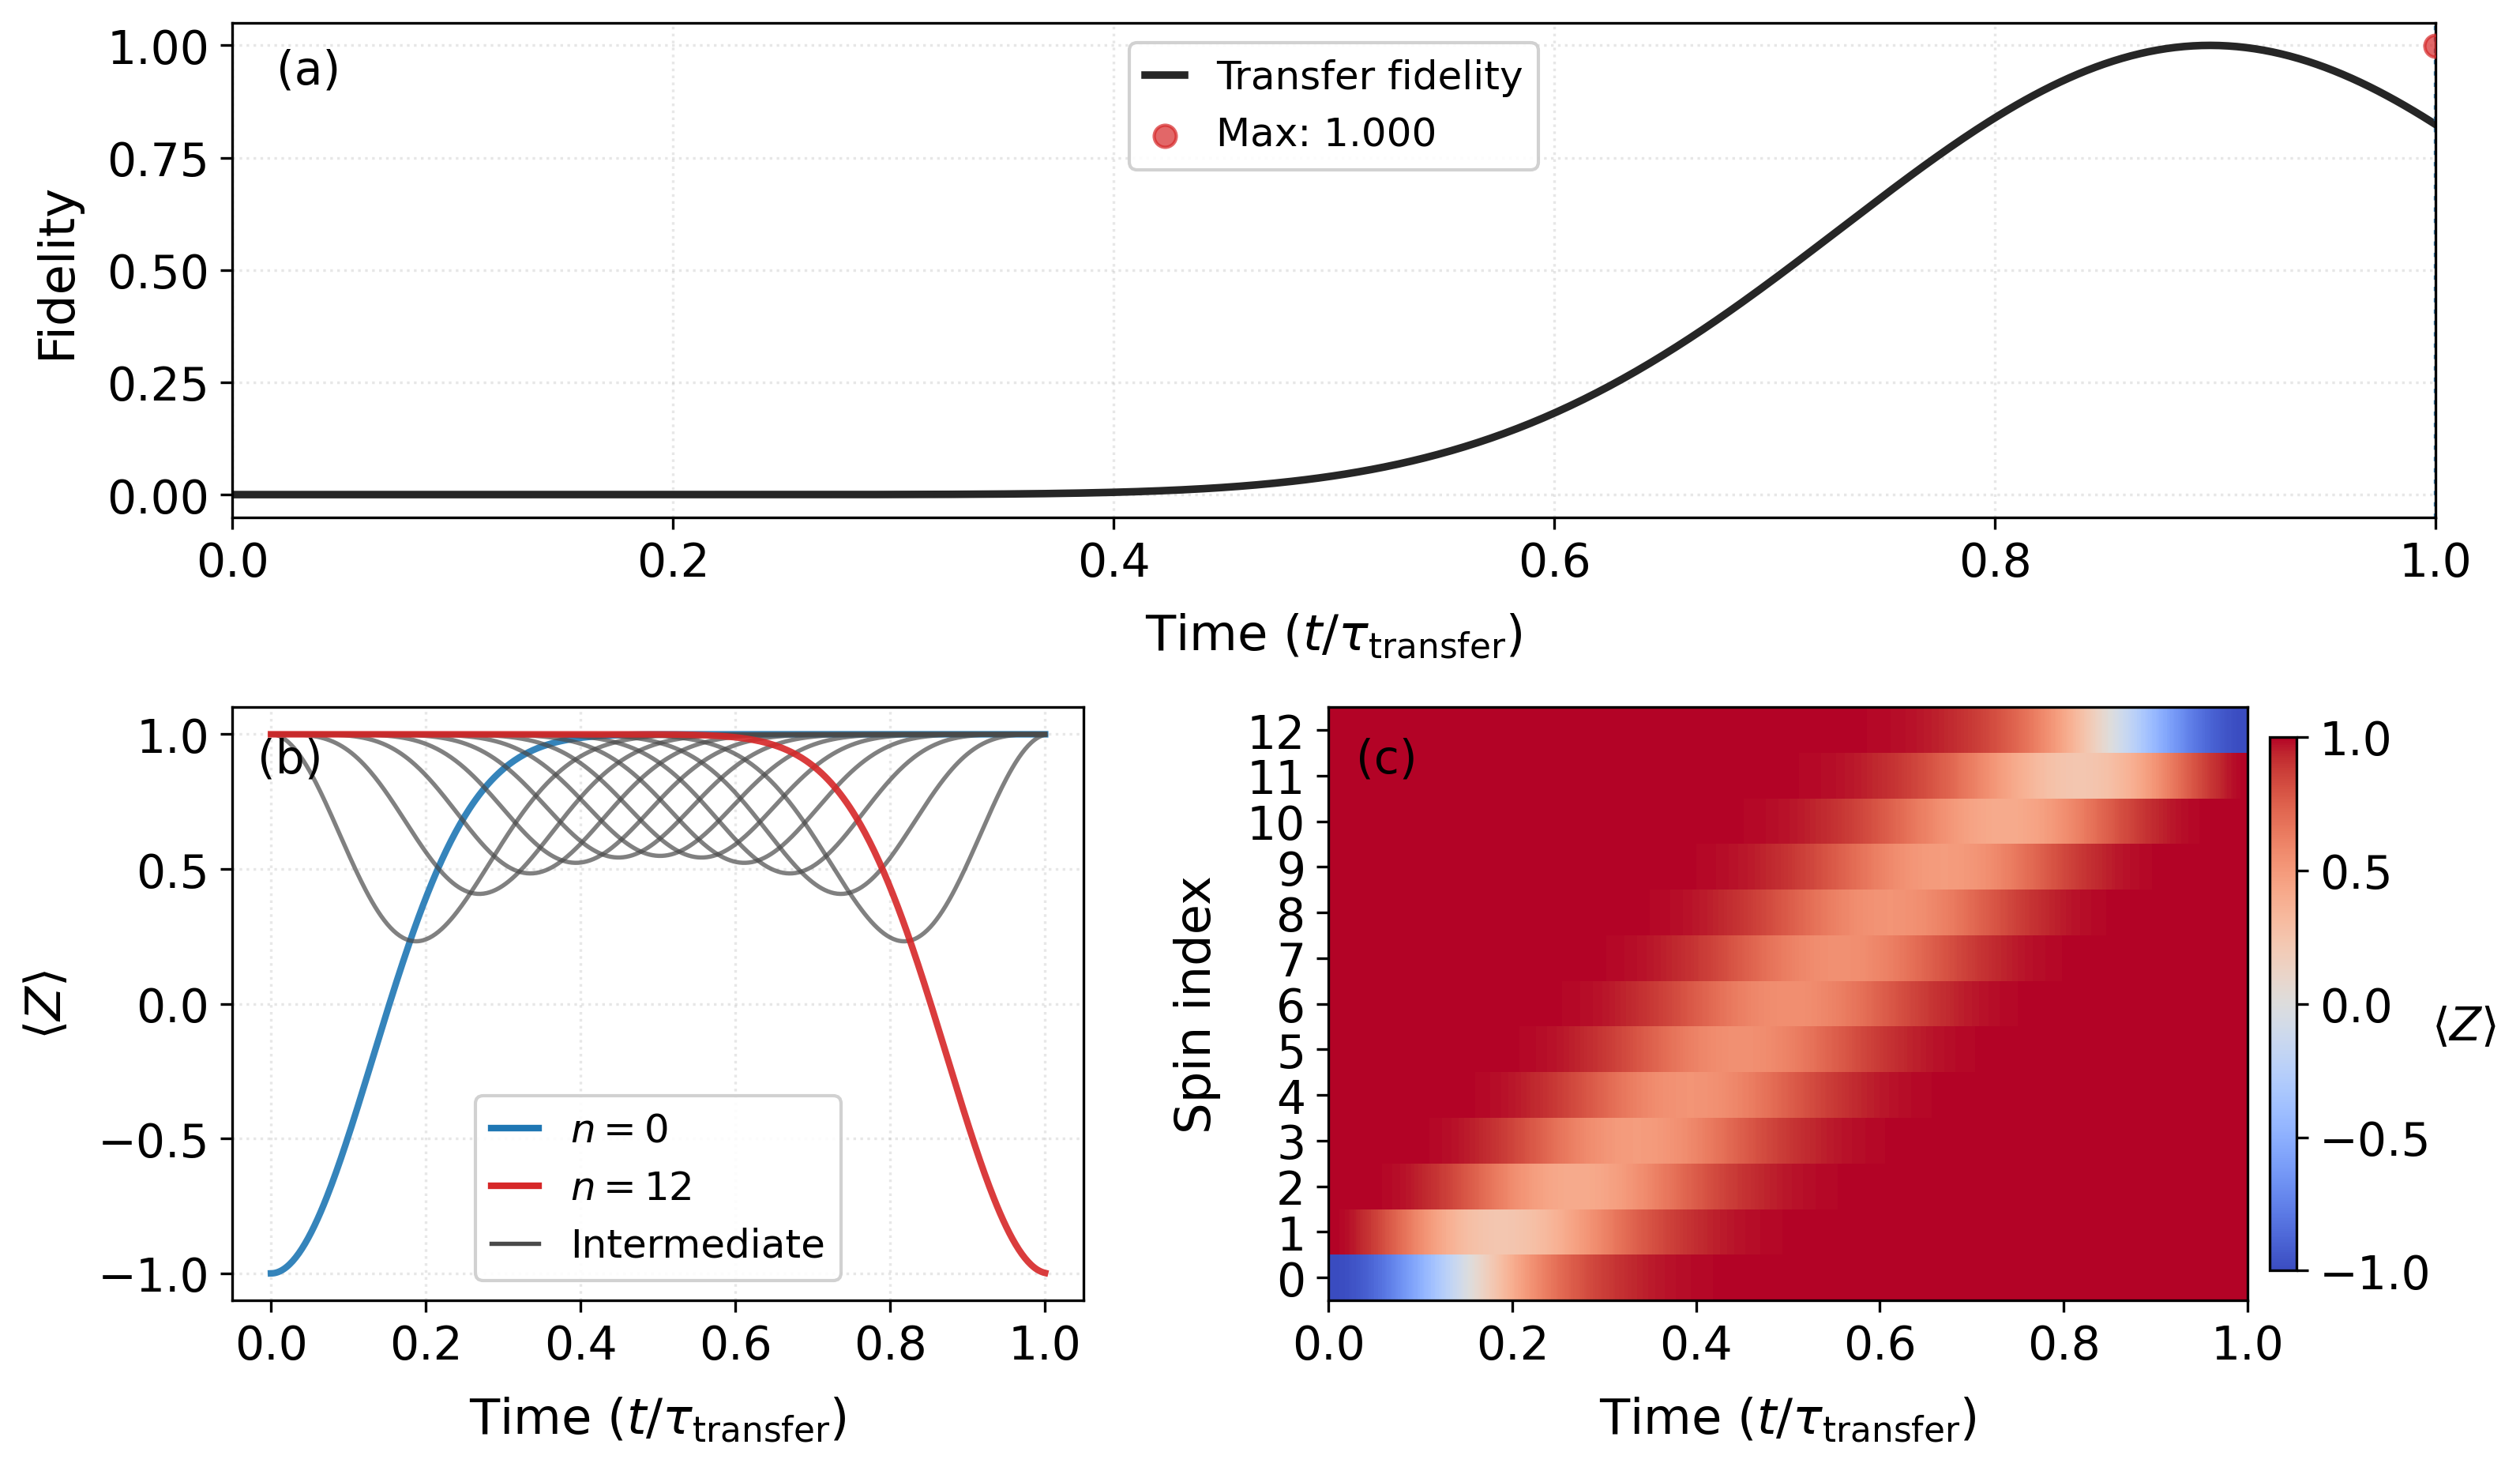

In [33]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.gridspec import GridSpec

# Create unified figure with better proportions
fig = plt.figure(figsize=(12, 7), dpi=300)  # Slightly shorter
gs = GridSpec(2, 2, width_ratios=[1, 1.3], height_ratios=[1, 1.2], 
             hspace=0.35, wspace=0.25)

# Custom colors and style parameters
first_color = '#1f77b4'  # Blue
last_color = '#d62728'   # Red
middle_color = '#4a4a4a' # Dark gray

# ====================== TOP ROW: FIDELITY PLOT ======================
ax1 = fig.add_subplot(gs[0, :])  # Span both columns

# Plot fidelity curve
ax1.plot(rescaled_time, full_fidelity_1, 
         color='#262626', 
         linewidth=2.3,
         label='Transfer fidelity')

# Mark maximum
ax1.scatter([1], [max_fidelity],
            color=last_color,
            s=45,
            alpha=0.7,
            zorder=5,
            label=f'Max: {max_fidelity:.3f}')

# Reference line
ax1.axvline(x=1, color=first_color, linestyle=':', linewidth=1.3, alpha=0.8)

# Formatting
ax1.set_xlabel(r'Time ($t/\tau_{\mathrm{transfer}}$)', fontsize=15, labelpad=8)
ax1.set_ylabel('Fidelity', fontsize=15, labelpad=8)
ax1.set_ylim(-0.05, 1.05)
ax1.set_xlim(0, rescaled_time[-1])
ax1.grid(True, linestyle=':', alpha=0.3)
ax1.legend(fontsize=12, framealpha=0.9, loc='upper center', handlelength=1)
ax1.tick_params(labelsize=14)

# Add panel label
ax1.text(0.02, 0.95, '(a)', transform=ax1.transAxes, 
         fontsize=14, va='top')

# ====================== BOTTOM LEFT: SPIN LINES ======================
ax2 = fig.add_subplot(gs[1, 0])

# Plot spin trajectories
for i in range(N):
    lineprops = {
        'color': first_color if i == 0 else (last_color if i == N-1 else middle_color),
        'lw': 2 if i in [0, N-1] else 1.3,
        'alpha': 0.9 if i in [0, N-1] else 0.7,
    }
    ax2.plot(norm_time, magnetizations[:,i], **lineprops)

# Only label first and last
ax2.plot([], [], color=first_color, label=r'$n=0$', lw=2)
ax2.plot([], [], color=last_color, label=r'$n={}$'.format(N-1), lw=2)
if N > 2:
    ax2.plot([], [], color=middle_color, label='Intermediate', lw=1.3)

# Formatting
ax2.set_xlabel(r'Time ($t/\tau_{\mathrm{transfer}}$)', fontsize=15, labelpad=8)
ax2.set_ylabel(r'$\langle Z \rangle$', fontsize=15, labelpad=8)
ax2.set_ylim(-1.1, 1.1)
ax2.grid(True, linestyle=':', alpha=0.3)
ax2.tick_params(labelsize=14)

# Compact legend
ax2.legend(fontsize=12, framealpha=0.9, loc='lower center', 
           handlelength=1.2, borderpad=0.4)

# Panel label
ax2.text(0.03, 0.95, '(b)', transform=ax2.transAxes, 
         fontsize=14, va='top')

# ====================== BOTTOM RIGHT: HEATMAP ======================
ax3 = fig.add_subplot(gs[1, 1])

# Heatmap with improved contrast
heatmap = ax3.imshow(
    magnetizations.T,
    aspect='auto',
    cmap='coolwarm',
    vmin=-1,
    vmax=1,
    extent=(0, 1, 0, N),
    origin='lower',
    interpolation='none'
)

# Compact colorbar
cbar = fig.colorbar(heatmap, ax=ax3, pad=0.02, shrink=0.9)
cbar.set_label(r'$\langle Z \rangle$', fontsize=14, rotation=0, labelpad=10)
cbar.ax.tick_params(labelsize=14)

# Formatting
ax3.set_xlabel(r'Time ($t/\tau_{\mathrm{transfer}}$)', fontsize=15, labelpad=8)
ax3.set_ylabel('Spin index', fontsize=15, labelpad=8)
ax3.set_yticks(np.arange(0.5, N+0.5, 1))
ax3.set_yticklabels(np.arange(N))
ax3.tick_params(labelsize=14)

# Panel label
ax3.text(0.03, 0.95, '(c)', transform=ax3.transAxes, 
         fontsize=14, va='top')

# ====================== GLOBAL FORMATTING ======================
# # Main title (optional - can remove if space is tight)
# fig.suptitle(r'Spin Chain Dynamics ($N={}$)'.format(N), 
#              fontsize=16, y=0.99)

# Final adjustments
plt.savefig('figures/good_figures/integrated_dynamics_v2.pdf', 
            bbox_inches='tight', dpi=300)
plt.show()

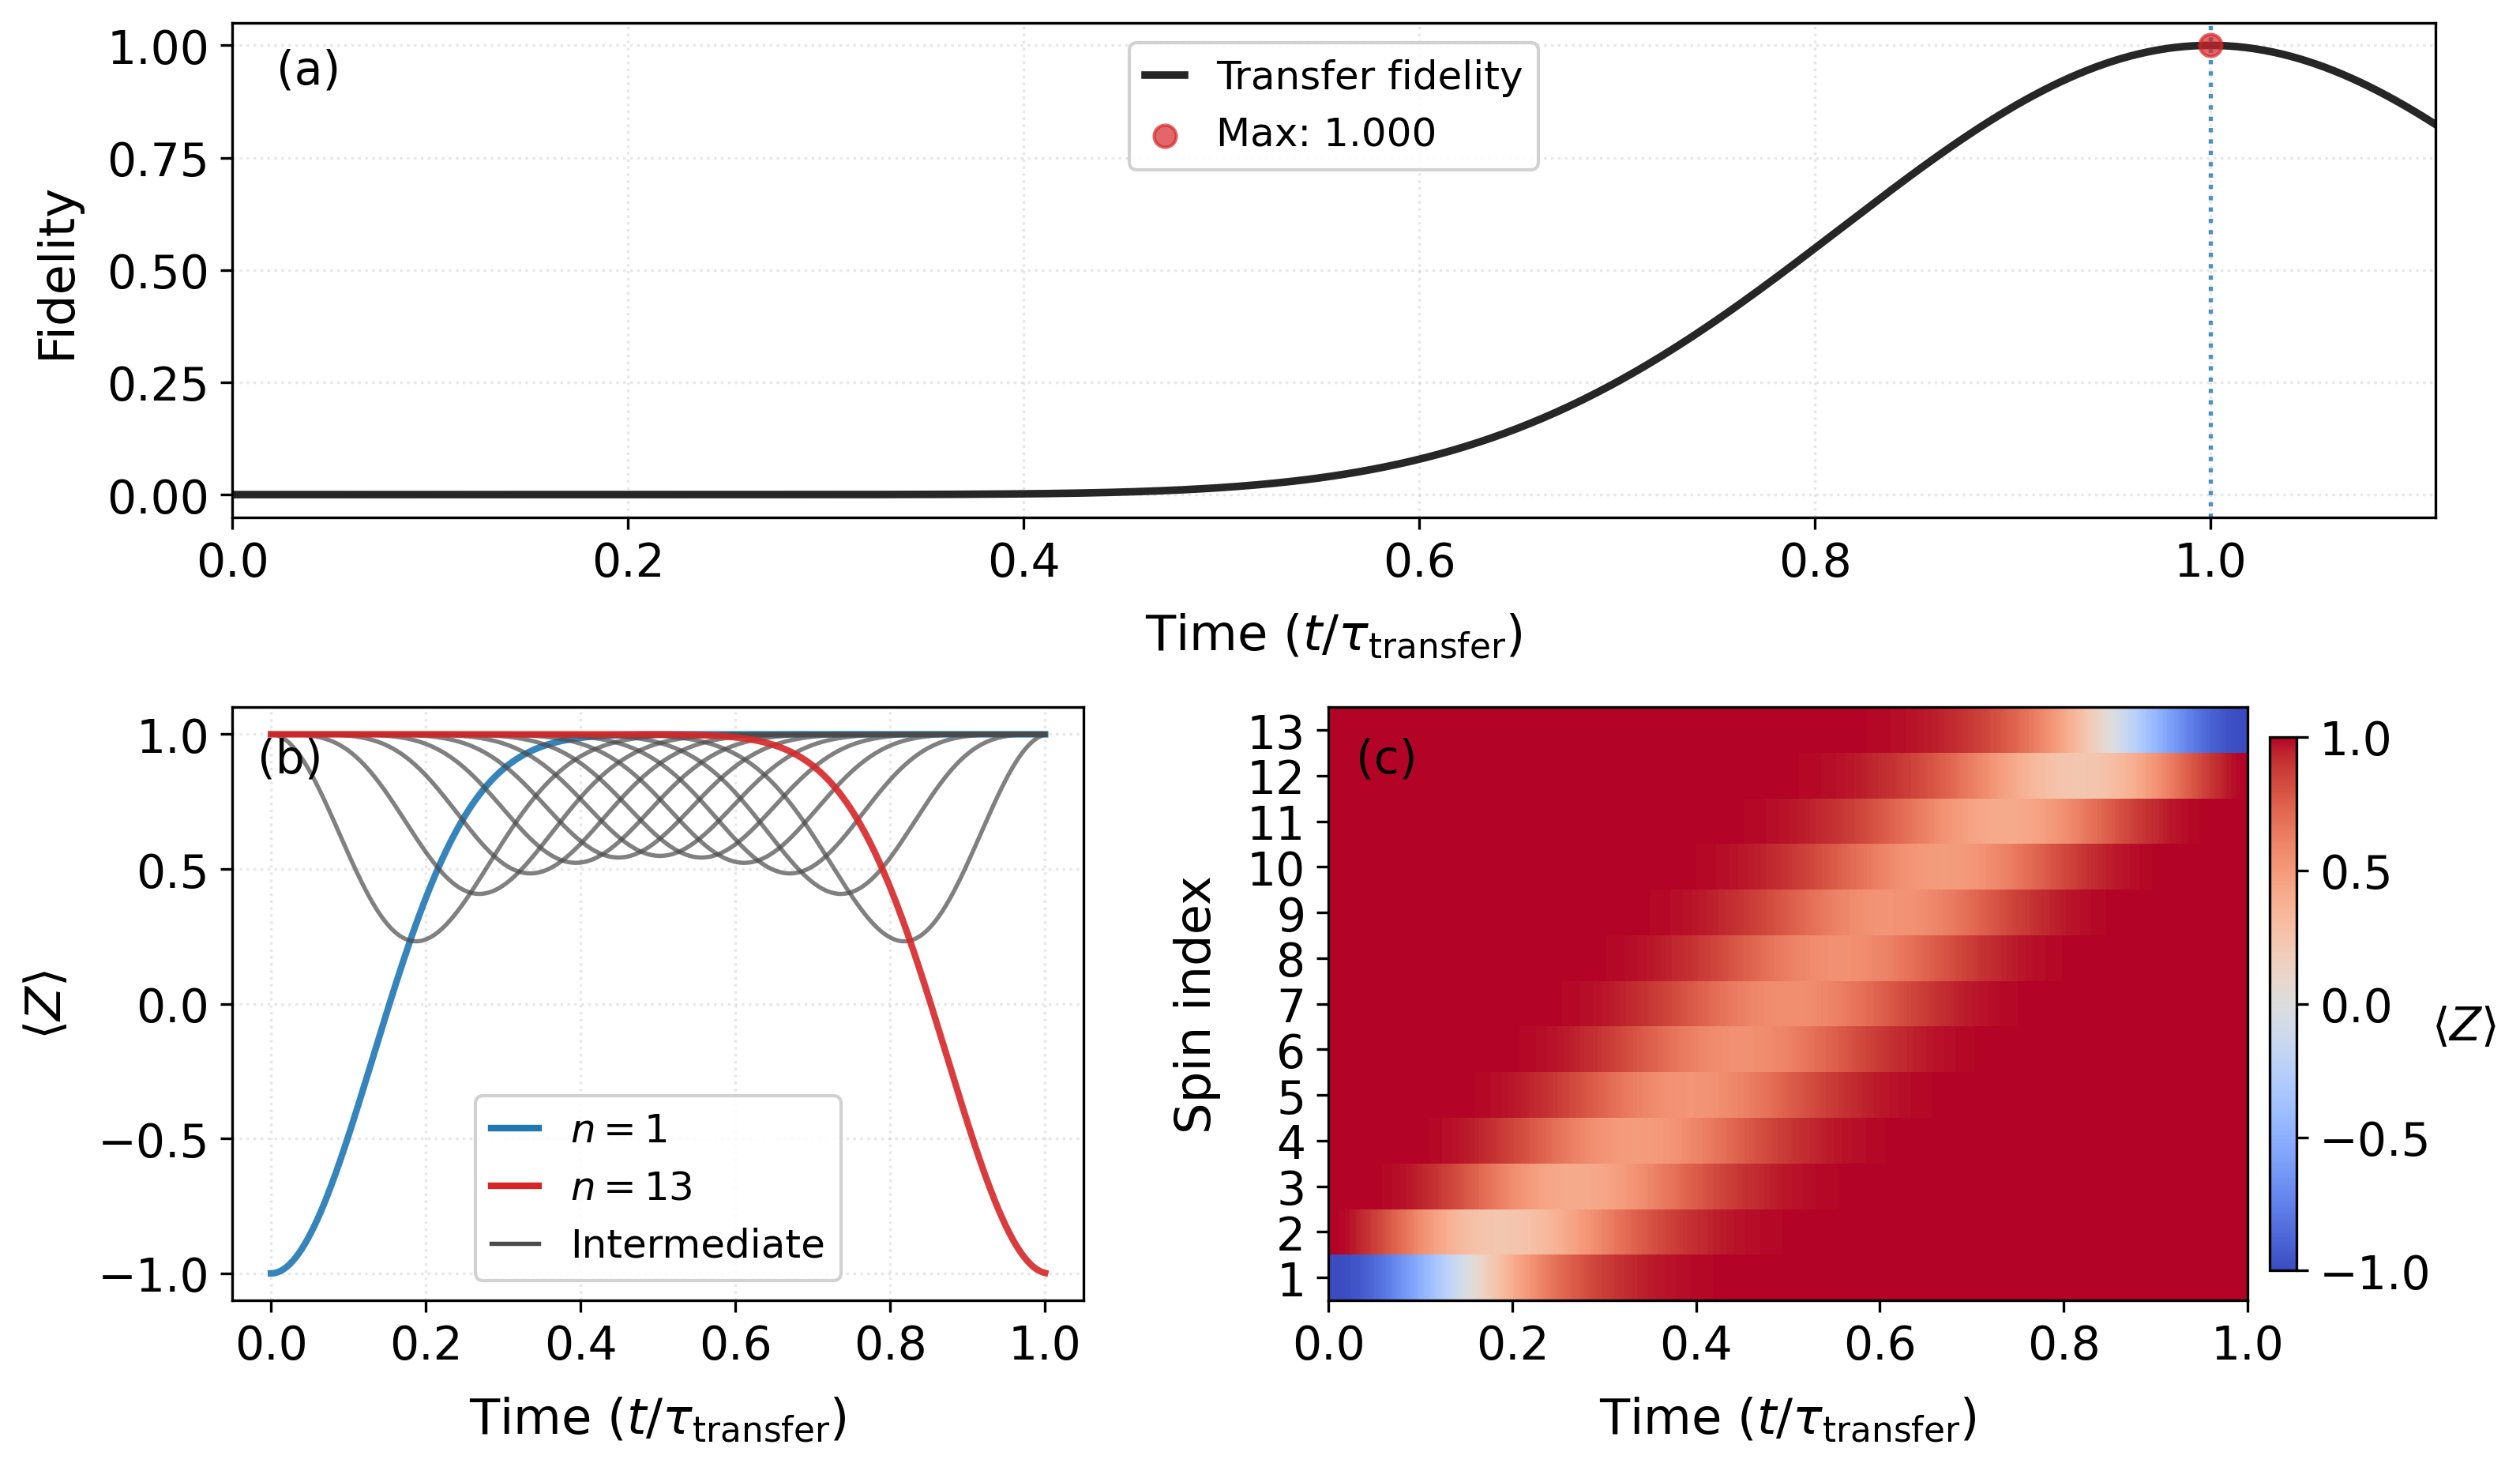

In [19]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.gridspec import GridSpec

# Find maximum fidelity point
max_fidelity = np.max(full_fidelity_1)
max_time_idx = np.argmax(full_fidelity_1)

# Rescale time axis so maximum occurs at t/τ = 1
original_time = np.linspace(0, 500, len(full_fidelity_1))  # Original 0-7 range
rescale_factor = original_time[max_time_idx]  # This will become 1 in new units
rescaled_time = original_time / rescale_factor

# Create unified figure with better proportions
fig = plt.figure(figsize=(12, 7), dpi=300)  # Slightly shorter
gs = GridSpec(2, 2, width_ratios=[1, 1.3], height_ratios=[1, 1.2], 
             hspace=0.35, wspace=0.25)

# Custom colors and style parameters
first_color = '#1f77b4'  # Blue
last_color = '#d62728'   # Red
middle_color = '#4a4a4a' # Dark gray

# ====================== TOP ROW: FIDELITY PLOT ======================
ax1 = fig.add_subplot(gs[0, :])  # Span both columns

# Plot fidelity curve
ax1.plot(rescaled_time, full_fidelity_1, 
         color='#262626', 
         linewidth=2.3,
         label='Transfer fidelity')

# Mark maximum
ax1.scatter([1], [max_fidelity],
            color=last_color,
            s=45,
            alpha=0.7,
            zorder=5,
            label=f'Max: {max_fidelity:.3f}')

# Reference line
ax1.axvline(x=1, color=first_color, linestyle=':', linewidth=1.3, alpha=0.8)

# Formatting
ax1.set_xlabel(r'Time ($t/\tau_{\mathrm{transfer}}$)', fontsize=15, labelpad=8)
ax1.set_ylabel('Fidelity', fontsize=15, labelpad=8)
ax1.set_ylim(-0.05, 1.05)
ax1.set_xlim(0, rescaled_time[-1])
ax1.grid(True, linestyle=':', alpha=0.3)
ax1.legend(fontsize=12, framealpha=0.9, loc='upper center', handlelength=1)
ax1.tick_params(labelsize=14)

# Add panel label
ax1.text(0.02, 0.95, '(a)', transform=ax1.transAxes, 
         fontsize=14, va='top')

# ====================== BOTTOM LEFT: SPIN LINES ======================
ax2 = fig.add_subplot(gs[1, 0])

# Plot spin trajectories
for i in range(N):
    magn = magnetizations[:,i]
    norm_time = np.linspace(0, 1, len(magn))
    lineprops = {
        'color': first_color if i == 0 else (last_color if i == N-1 else middle_color),
        'lw': 2 if i in [0, N-1] else 1.3,
        'alpha': 0.9 if i in [0, N-1] else 0.7,
    }
    ax2.plot(norm_time, magnetizations[:,i], **lineprops)

# Only label first and last
ax2.plot([], [], color=first_color, label=r'$n=1$', lw=2)
ax2.plot([], [], color=last_color, label=r'$n={}$'.format(N), lw=2)
if N > 2:
    ax2.plot([], [], color=middle_color, label='Intermediate', lw=1.3)

# Formatting
ax2.set_xlabel(r'Time ($t/\tau_{\mathrm{transfer}}$)', fontsize=15, labelpad=8)
ax2.set_ylabel(r'$\langle Z \rangle$', fontsize=15, labelpad=8)
ax2.set_ylim(-1.1, 1.1)
ax2.grid(True, linestyle=':', alpha=0.3)
ax2.tick_params(labelsize=14)

# Compact legend
ax2.legend(fontsize=12, framealpha=0.9, loc='lower center', 
           handlelength=1.2, borderpad=0.4)

# Panel label
ax2.text(0.03, 0.95, '(b)', transform=ax2.transAxes, 
         fontsize=14, va='top')

# ====================== BOTTOM RIGHT: HEATMAP ======================
ax3 = fig.add_subplot(gs[1, 1])

# Heatmap with improved contrast
heatmap = ax3.imshow(
    magnetizations.T,
    aspect='auto',
    cmap='coolwarm',
    vmin=-1,
    vmax=1,
    extent=(0, 1, 0, N),
    origin='lower',
    interpolation='none'
)

# Compact colorbar
cbar = fig.colorbar(heatmap, ax=ax3, pad=0.02, shrink=0.9)
cbar.set_label(r'$\langle Z \rangle$', fontsize=14, rotation=0, labelpad=10)
cbar.ax.tick_params(labelsize=14)

# Formatting
ax3.set_xlabel(r'Time ($t/\tau_{\mathrm{transfer}}$)', fontsize=15, labelpad=8)
ax3.set_ylabel('Spin index', fontsize=15, labelpad=8)
ax3.set_yticks(np.arange(0.5, N+0.5, 1))
ax3.set_yticklabels(np.arange(1,N+1))
ax3.tick_params(labelsize=14)

# Panel label
ax3.text(0.03, 0.95, '(c)', transform=ax3.transAxes, 
         fontsize=14, va='top')

# ====================== GLOBAL FORMATTING ======================
# # Main title (optional - can remove if space is tight)
# fig.suptitle(r'Spin Chain Dynamics ($N={}$)'.format(N), 
#              fontsize=16, y=0.99)

# Final adjustments
plt.savefig('figures/good_figures/integrated_dynamics_standard.pdf', 
            bbox_inches='tight', dpi=300)
plt.show()